## Feature Engineering (Özellik Mühendisliği)

Bu notebook üzerinde amacımız ham sensör verisinden trendleri ve değişimleri yakalayan yeni özellikler türetmek.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Ayarlar
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

# Temiz Veriyi Yükle
data_path = '../data/processed/sensor_cleaned.csv'
if os.path.exists(data_path):
    df = pd.read_csv(data_path, parse_dates=['timestamp'], index_col='timestamp')
    print(f"Veri Yüklendi. Boyut: {df.shape}")
else:
    raise FileNotFoundError("Önce 01_EDA notebook'unu çalıştırmalısın.")

Veri Yüklendi. Boyut: (220320, 52)


- Yukarda yüklediğimiz temiz ham veri üzerinde matematiksel işlemler yapacağız. 
- Hareketli Ortalama ile 3 ve 24 saatlik pencerelerle ortalama alınacak
- Standart sapma ile verideki dalgalanma ölçülecek.
- Lag (Gecikme): "Şu anki değer" ile "1 saat önceki değer" arasındaki fark hesaplanacak.

In [2]:
def make_features(df):
    df_eng = df.copy()
    
    sensor_cols = [c for c in df.columns if c.startswith('sensor')]
    
    windows = [3, 12, 24]
    
    print("Özellikler türetiliyor... (Biraz zaman alabilir)")
    
    new_features = []
    
    for window in windows:
        w_size = window * 60  # saat değil dakika
        
        for col in sensor_cols:
            # Rolling mean ve std özelliklerini listeye ekle
            roll_mean = df_eng[col].rolling(window=w_size, min_periods=1).mean()
            roll_mean.name = f'{col}_roll_mean_{window}h'
            new_features.append(roll_mean)
            
            roll_std = df_eng[col].rolling(window=w_size, min_periods=1).std()
            roll_std.name = f'{col}_roll_std_{window}h'
            new_features.append(roll_std)

    for col in sensor_cols:
        # Diff özelliğini listeye ekle
        diff_1h = df_eng[col] - df_eng[col].shift(60)
        diff_1h.name = f'{col}_diff_1h'
        new_features.append(diff_1h)
    
    # Tüm yeni özellikleri tek seferde birleştir (PerformanceWarning çözümü)
    if new_features:
        df_features = pd.concat(new_features, axis=1)
        df_eng = pd.concat([df_eng, df_features], axis=1)
    
    # CRITICAL FIX: Veri sızıntısını önlemek için 'bfill' kaldırıldı
    # Sadece 'ffill' (ileri dönük doldurma) kullanılabilir
    df_eng = df_eng.fillna(method='ffill')
    
    # Rolling window ve shift nedeniyle oluşan baştaki NaN satırlarını atıyoruz
    # En büyük pencere 24 saat = 1440 dakika
    df_eng = df_eng.dropna()
    
    print(f"Yeni Boyut: {df_eng.shape}")
    print(f"Türetilen Özellik Sayısı: {len(new_features)}")
    
    return df_eng

df_features = make_features(df)

Özellikler türetiliyor... (Biraz zaman alabilir)


C:\Users\Oznur\AppData\Local\Temp\ipykernel_9436\431333664.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_eng = df_eng.fillna(method='ffill')


Yeni Boyut: (220260, 409)
Türetilen Özellik Sayısı: 357


- Artık veri seti daha zengin durumda. Model zaman algısı kazandı.
- Şimdi yaptıklarımızı görselleştirelim. 

Çizilen Trend Sütunu: sensor_04_roll_mean_24h


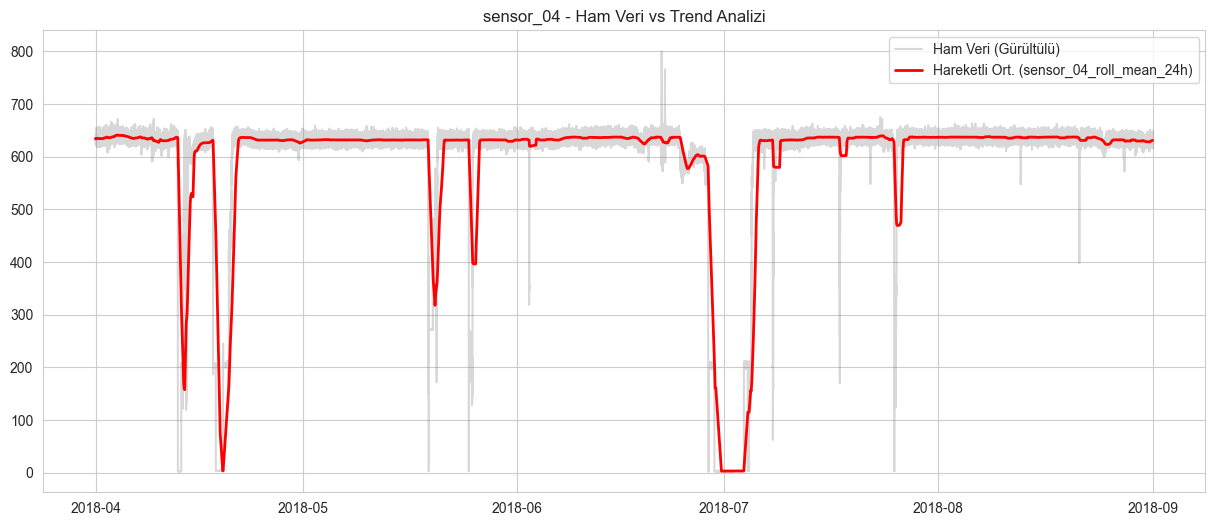

In [3]:
import matplotlib.pyplot as plt

sensor = 'sensor_04' # Örnek sensör

rolling_cols = [c for c in df_features.columns if sensor in c and 'roll_mean' in c]

target_col = rolling_cols[-1]  # En büyük pencere

print(f"Çizilen Trend Sütunu: {target_col}")

plt.figure(figsize=(15, 6))

plt.plot(df_features.index, df_features[sensor], label='Ham Veri (Gürültülü)', alpha=0.3, color='gray')

# Hareketli Ortalama 
plt.plot(df_features.index, df_features[target_col], label=f'Hareketli Ort. ({target_col})', color='red', linewidth=2)

plt.title(f"{sensor} - Ham Veri vs Trend Analizi")
plt.legend()
plt.show()

- Kırmızı çizginin, gürültülü gri verinin ortasından bir "Trend" çizgisi gibi aktığını gördük. Bu, modelin artık gürültüye takılmadan ana resmi görebileceğini kanıtladı.
- Baseline'da kullandığımız mantıkla (Arızadan önceki 24 saat = 1) hedef değişkeni (y) tekrar oluşturacağız ve kaydedeceğiz. Sonucunda artık elimizde Baseline modelin kullandığı ham veri değil, zenginleştirilmiş (enriched) ve akıllı veri seti olacak.

In [4]:
def create_target(df, window_hours=24):
    df_labeled = df.copy()
    df_labeled['y'] = 0
    broken_indices = df_labeled[df_labeled['machine_status'] == 'BROKEN'].index
    for fail_time in broken_indices:
        start_time = fail_time - pd.Timedelta(hours=window_hours)
        mask = (df_labeled.index >= start_time) & (df_labeled.index <= fail_time)
        df_labeled.loc[mask, 'y'] = 1
    df_final = df_labeled[df_labeled['machine_status'] != 'RECOVERING'].drop(columns=['machine_status'])
    return df_final

df_final = create_target(df_features, window_hours=24)

save_path = '../data/processed/sensor_enriched.csv'
df_final.to_csv(save_path)
print(f"Zenginleştirilmiş veri seti kaydedildi: {save_path}")
print(f"Son Boyut: {df_final.shape}")

Zenginleştirilmiş veri seti kaydedildi: ../data/processed/sensor_enriched.csv
Son Boyut: (205783, 409)


## Sonuçlar ve Kararlar

Baseline modelin "Recall: 0.00" (Arızaları yakalayamama) sorununu çözmek amacıyla, bu notebook'ta ham veriye **zaman algısı** ve **trend bilgisi** kazandırılmıştır.

### 1. Uygulanan Dönüşümler (Engineering Steps)
Modelin anlık gürültüden (Noise) etkilenmemesi ve büyük resmi görebilmesi için veri seti şu tekniklerle zenginleştirilmiştir.

* **Rolling Statistics (Hareketli İstatistikler):**
    * Her sensör için **3 saatlik** ve **12/24 saatlik** (seçilen pencereye göre) hareketli ortalama (`mean`) ve standart sapma (`std`) türetildi.
    * **Amaç:** Anlık titreşimleri filtreleyip, sensörün genel gidişatını (Isınıyor mu? Basınç artıyor mu?) modele göstermek.
* **Lag Features (Gecikmeli Değişkenler):**
    * Verilerin 1 saat önceki değerleri (`shift`) ile şu anki değerleri arasındaki farklar (`diff`) hesaplandı.
    * **Amaç:** Değişim hızını (Velocity) yakalamak. Ani düşüş veya yükselişler artık matematiksel olarak ifade edilebilir durumda.

### 2. Görsel Doğrulama
* Yapılan görselleştirmede, ham verinin (Gri Çizgiler) çok gürültülü olduğu, ancak türetilen **Rolling Mean** (Kırmızı Çizgi) özelliğinin ana trendi pürüzsüz bir şekilde takip ettiği gözlemlendi.
* Bu durum, modelin artık "sinyali" gürültüden ayırt edebileceğini kanıtlamaktadır.

### 3. Hazırlanan Veri Seti
* Türetilen özelliklerle sütun sayısı artırılmış ve zenginleştirilmiş veri seti **`data/processed/sensor_enriched.csv`** olarak kaydedildi.
* Hedef değişken (`y`), arıza öncesi 24 saatlik pencere kuralına göre yeniden etiketlendi.

**Sonraki Adım:** Bu zenginleştirilmiş veri setini kullanarak **04_ModelOptimization.ipynb** aşamasında LightGBM/XGBoost modellerini eğitmek ve Baseline skorunu (Recall: 0.00) yukarı çekmek.